In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from helper_functions import *
import pickle
import geopandas as gpd
import os

In [37]:
# esmr_data = read_esmr(save=False)
unique_parameter_codes = pd.read_csv('processed_data/step1/dmr_esmr_mapping.csv')['PARAMETER_CODE'].unique()
ref_frequency = pd.read_csv('data/dmrs/REF_FREQUENCY_OF_ANALYSIS.csv')

In [38]:
# random codes for testing
unique_parameter_codes_rand = np.random.choice(unique_parameter_codes, 20, replace=False)

In [39]:
data_dict = read_all_dmrs(save=False) # change to True to save the facility_param_dict to a pickle file
total_event_sum = 0
for year in analysis_range:
    total_event_sum += len(data_dict[year])
print(f'{total_event_sum:,} DMR events in data_dict')

current_year = 2023
regenerate_facility_param_dict = True

if regenerate_facility_param_dict:
    # Create a subset of the data_dict for each facility (from NPDES/DMR list)for each year in the analysis range.
    # For each facility, calculate the percentage of reports for each parameter which are within the buffer % of the limit.
    facility_param_dict = {}
    parameter_outlier_bounds = pd.read_csv('processed_data/step3/parameter_outlier_bounds.csv', dtype={'PARAMETER_CODE': str, 'LOWER_BOUND': float, 'UPPER_BOUND': float})

    # Pre-filter the data for selected pollutants
    filtered_data_dict = {year: data_dict[year][data_dict[year]['PARAMETER_CODE'].isin(unique_parameter_codes_rand)] for year in analysis_range}
    count = 0
    for NPDES_code in data_dict[current_year]['EXTERNAL_PERMIT_NMBR'].unique():
        count += 1
        if count % 10 == 0:
            print(f'{count} facilities processed')
        facility_param_dict[NPDES_code] = {}

        relevant_parameter_codes = [
            code for code in unique_parameter_codes_rand
            if any((filtered_data_dict[current_year]['EXTERNAL_PERMIT_NMBR'] == NPDES_code) & 
                   (filtered_data_dict[current_year]['PARAMETER_CODE'] == code))
        ]
        
        for parameter_code in relevant_parameter_codes:
            # Get all unique combinations of LIMIT_UNIT_DESC, LIMIT_SET_SCHEDULE_ID, and MONITORING_LOCATION_CODE for this facility and parameter
            facility_parameter_combinations = set()
            combinations = filtered_data_dict[current_year][
                (filtered_data_dict[current_year]['EXTERNAL_PERMIT_NMBR'] == NPDES_code) & 
                (filtered_data_dict[current_year]['PARAMETER_CODE'] == parameter_code)
            ][['LIMIT_UNIT_DESC', 'LIMIT_VALUE_TYPE_CODE', 'MONITORING_LOCATION_CODE']].drop_duplicates().values.tolist()
            facility_parameter_combinations.update(map(tuple, combinations))
            
            facility_param_dict[NPDES_code][parameter_code] = {}
            
            for LIMIT_UNIT_DESC, LIMIT_VALUE_TYPE_CODE, MONITORING_LOCATION_CODE in facility_parameter_combinations:
                # Make a df of all rows where PARAMETER_CODE, LIMIT_UNIT_DESC, LIMIT_SET_SCHEDULE_ID, and MONITORING_LOCATION_CODE match for all years in analysis_range
                facility_parameter_data = pd.concat([filtered_data_dict[year][
                    (filtered_data_dict[year]['EXTERNAL_PERMIT_NMBR'] == NPDES_code) & 
                    (filtered_data_dict[year]['PARAMETER_CODE'] == parameter_code) &
                    (filtered_data_dict[year]['LIMIT_UNIT_DESC'] == LIMIT_UNIT_DESC) &
                    (filtered_data_dict[year]['LIMIT_VALUE_TYPE_CODE'] == LIMIT_VALUE_TYPE_CODE) &
                    (filtered_data_dict[year]['MONITORING_LOCATION_CODE'] == MONITORING_LOCATION_CODE)
                ] for year in analysis_range])

                # loop through each LIMIT_SET_SCHEDULE_ID and get values for each
                for LIMIT_SET_SCHEDULE_ID in facility_parameter_data['LIMIT_SET_SCHEDULE_ID'].unique():
                    facility_parameter_data_subset = facility_parameter_data[facility_parameter_data['LIMIT_SET_SCHEDULE_ID'] == LIMIT_SET_SCHEDULE_ID]
                    if len(facility_parameter_data_subset) > 1:                    
                        dates = pd.to_numeric(facility_parameter_data['MONITORING_PERIOD_END_DATE_NUMERIC'], errors='coerce')
                        datetimes = pd.to_datetime(facility_parameter_data['MONITORING_PERIOD_END_DATE'], errors='coerce')
                        values = pd.to_numeric(facility_parameter_data['DMR_VALUE_STANDARD_UNITS'], errors='coerce')
                        qualifiers = facility_parameter_data['LIMIT_VALUE_QUALIFIER_CODE'].values
                        limits = pd.to_numeric(facility_parameter_data['LIMIT_VALUE_STANDARD_UNITS'], errors='coerce')
                        frequency_code = facility_parameter_data['LIMIT_FREQ_OF_ANALYSIS_CODE'].values

                        # Remove outliers using limit bounds and interquartile range
                        bounds = parameter_outlier_bounds[parameter_outlier_bounds['PARAMETER_CODE'] == parameter_code]
                        parameter_desc = ref_parameter.loc[ref_parameter['PARAMETER_CODE'] == parameter_code, 'PARAMETER_DESC'].values[0]
                        # define bounds
                        if "percent" in parameter_desc.lower():
                            lower_bound = 0
                            upper_bound = 100
                        else:
                            lower_bound = bounds['LOWER_BOUND'].values[0] if not bounds.empty else None
                            upper_bound = bounds['UPPER_BOUND'].values[0] if not bounds.empty else None
                        # remove outliers using bounds and interquartile range
                        if len(values) >= 5:
                            Q1 = np.percentile(values, 25)
                            Q3 = np.percentile(values, 75)
                            IQR = Q3 - Q1
                            lower_fence = Q1 - 1.5 * IQR
                            upper_fence = Q3 + 1.5 * IQR
                            outlier_mask = (values < lower_fence) | (values > upper_fence)
                            if lower_bound is not None:
                                outlier_mask = outlier_mask | (values < lower_bound)
                            if upper_bound is not None:
                                outlier_mask = outlier_mask | (values > upper_bound)
                            value_mask = ~outlier_mask
                        else:
                            outlier_mask = np.zeros(len(values), dtype=bool)
                            value_mask = np.ones(len(values), dtype=bool)
                    
                        # recalculate the mean and std for the cleaned data
                        mean = np.mean(values[value_mask])
                        std = np.std(values[value_mask])
                        
                        # find the slope and intercept of the trend line for the cleaned values
                        if len(values[value_mask]) > 1:
                            slope, intercept = np.polyfit(dates[value_mask], values[value_mask], 1)
                        else:
                            slope = 0
                            intercept = 0
                            values = pd.Series([0], index=[0])
                            dates = [0]

                        key = (LIMIT_UNIT_DESC, LIMIT_SET_SCHEDULE_ID, LIMIT_VALUE_TYPE_CODE, MONITORING_LOCATION_CODE)
                        facility_param_dict[NPDES_code][parameter_code][key] = {
                            'slope': slope,
                            'intercept': intercept,
                            'limits': limits,
                            'qualifiers': qualifiers,
                            'dates': dates,
                            'values': values.values,
                            'datetimes': datetimes,
                            'frequency_code': frequency_code,
                            'outlier_mask': outlier_mask,
                            'value_mask': value_mask,
                            'mean': mean,
                            'std': std
                        }
    with open('processed_data/step3/facility_param_dict.pkl', 'wb') as f:
        pickle.dump(facility_param_dict, f)
else:
    facility_param_dict = pickle.load(open('processed_data/step3/facility_param_dict.pkl', 'rb'))

499,363 DMR events in data_dict
10 facilities processed
20 facilities processed
30 facilities processed
40 facilities processed
50 facilities processed
60 facilities processed
70 facilities processed
80 facilities processed
90 facilities processed
100 facilities processed
110 facilities processed
120 facilities processed
130 facilities processed
140 facilities processed
150 facilities processed
160 facilities processed
170 facilities processed
180 facilities processed
190 facilities processed
200 facilities processed


In [40]:
def get_facilities_with_slope_and_near_exceedance(facility_param_dict, slope_threshold, limit_threshold, print_counts=False):
    facilities_with_slope = []
    facilities_with_near_exceedance = []

    for NPDES_code in facility_param_dict.keys():
        for parameter_code in facility_param_dict[NPDES_code].keys():
            for (LIMIT_UNIT_DESC, LIMIT_SET_SCHEDULE_ID, LIMIT_VALUE_TYPE_CODE, MONITORING_LOCATION_CODE), limit_data in facility_param_dict[NPDES_code][parameter_code].items():
                slope = limit_data['slope']
                limits = limit_data['limits']
                qualifiers = limit_data['qualifiers']
                mean = limit_data['mean']
                std = limit_data['std']

                # Check for facilities with significant slope based on qualifier
                if qualifiers[0] in ['<=', '<'] and slope > slope_threshold:
                    near_exceedance = (mean + std > (1-limit_threshold)*limits.values[0])
                    has_slope = (slope > slope_threshold)
                elif qualifiers[0] in ['>=', '>'] and slope < -slope_threshold:
                    near_exceedance = (mean - std < (1+limit_threshold)*limits.values[0])
                    has_slope = (slope < -slope_threshold)
                else:
                    has_slope, near_exceedance = False, False

                if has_slope:
                    facilities_with_slope.append((NPDES_code, parameter_code, LIMIT_UNIT_DESC, LIMIT_SET_SCHEDULE_ID, LIMIT_VALUE_TYPE_CODE, MONITORING_LOCATION_CODE))
                if near_exceedance:
                    facilities_with_near_exceedance.append((NPDES_code, parameter_code, LIMIT_UNIT_DESC, LIMIT_SET_SCHEDULE_ID, LIMIT_VALUE_TYPE_CODE, MONITORING_LOCATION_CODE))

    facilities_with_slope_and_near_exceedance = list(set(facilities_with_slope) & set(facilities_with_near_exceedance))
    if print_counts:
        print(f'{len(facilities_with_slope)} facility-parameter-limit pairs with slope > {slope_threshold*100}%')
        print(f'{len(facilities_with_near_exceedance)} facility-parameter-limit pairs with mean + std reaching > {limit_threshold*100}% of limit')
        print(f'{len(facilities_with_slope_and_near_exceedance)} facility-parameter-limit pairs with both slope and near exceedance')
        print(f'{len(set([facility[0] for facility in facilities_with_slope_and_near_exceedance]))} facilities that have at least one parameter-limit pair with slope and near exceedance')
    return facilities_with_slope_and_near_exceedance

slope_threshold = 0.05
limit_threshold = 0.1
facilities_with_slope_and_near_exceedance = get_facilities_with_slope_and_near_exceedance(facility_param_dict, 
                                                                                          slope_threshold, 
                                                                                          limit_threshold,
                                                                                          print_counts=True)
facilities_with_slope_and_near_exceedance_df = pd.DataFrame(facilities_with_slope_and_near_exceedance, columns=['NPDES_CODE', 'PARAMETER_CODE', 'LIMIT_UNIT_DESC', 'LIMIT_SET_SCHEDULE_ID', 'LIMIT_VALUE_TYPE_CODE', 'MONITORING_LOCATION_CODE'])

228 facility-parameter-limit pairs with slope > 5.0%
11 facility-parameter-limit pairs with mean + std reaching > 10.0% of limit
11 facility-parameter-limit pairs with both slope and near exceedance
3 facilities that have at least one parameter-limit pair with slope and near exceedance


### Plot timeseries for each facility-parameter combination

In [41]:
facilities_grouped = facilities_with_slope_and_near_exceedance_df.groupby('NPDES_CODE')

# Create a single legend for all plots
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='b', label='Data', markersize=8, linestyle='None'),
    plt.Line2D([0], [0], color='k', linestyle='--', label='Trend'),
    plt.Line2D([0], [0], marker='*', color='red', label='Outliers', markersize=10, linestyle='None'),
    plt.Rectangle((0,0), 1, 1, fc="lightgreen", alpha=0.3, label='In Compliance'),
    plt.Rectangle((0,0), 1, 1, fc="lightcoral", alpha=0.3, label='Out of Compliance')
]

# Create a separate legend for histograms
histogram_legend_elements = [
    plt.Line2D([0], [0], color='red', linestyle='--', label='Mean + Std'),
    plt.Line2D([0], [0], color='grey', linestyle='-', label='Limit')
]

# Loop through each facility (NPDES_CODE) that has at least one parameter with slope and near exceedance
for NPDES_CODE, group in facilities_grouped:
    # Count total number of parameters and combinations
    total_combinations = sum(
        len(group[(group['PARAMETER_CODE'] == param) & 
                  (group['LIMIT_UNIT_DESC'] == unit) & 
                  (group['LIMIT_SET_SCHEDULE_ID'] == schedule) & 
                  (group['LIMIT_VALUE_TYPE_CODE'] == value_type) & 
                  (group['MONITORING_LOCATION_CODE'] == location)].drop_duplicates())
        for param in group['PARAMETER_CODE'].unique()
        for unit in group['LIMIT_UNIT_DESC'].unique()
        for schedule in group['LIMIT_SET_SCHEDULE_ID'].unique()
        for value_type in group['LIMIT_VALUE_TYPE_CODE'].unique()
        for location in group['MONITORING_LOCATION_CODE'].unique()
    )
    
    # Create a figure with flexible layout
    fig = plt.figure(figsize=(16, 3*total_combinations))
    gs = gridspec.GridSpec(total_combinations, 2, width_ratios=[2, 1])
    
    row = 0
    for PARAMETER_CODE, param_group in group.groupby('PARAMETER_CODE'):
        PARAMETER_CODE = str(PARAMETER_CODE)
        parameter_desc = ref_parameter.loc[ref_parameter['PARAMETER_CODE'] == PARAMETER_CODE, 'PARAMETER_DESC'].values[0]
        
        # Get unique combinations of limit identifiers for this parameter
        combinations = param_group.groupby(['LIMIT_UNIT_DESC', 'LIMIT_SET_SCHEDULE_ID', 'LIMIT_VALUE_TYPE_CODE', 'MONITORING_LOCATION_CODE'])
        
        for (LIMIT_UNIT_DESC, LIMIT_SET_SCHEDULE_ID, LIMIT_VALUE_TYPE_CODE, MONITORING_LOCATION_CODE), combo_group in combinations:
            ax_timeseries = fig.add_subplot(gs[row, 0])
            ax_histogram = fig.add_subplot(gs[row, 1])
            key = (LIMIT_UNIT_DESC, LIMIT_SET_SCHEDULE_ID, LIMIT_VALUE_TYPE_CODE, MONITORING_LOCATION_CODE)
            
            # Filter data for this combination of NPDES_CODE, PARAMETER_CODE, and key
            if key in facility_param_dict[NPDES_CODE][PARAMETER_CODE]:
                data = facility_param_dict[NPDES_CODE][PARAMETER_CODE][key]
                values = np.array(data['values'])
                dates = np.array(data['dates'].values)
                outlier_mask = np.array(data['outlier_mask'])
                value_mask = np.array(data['value_mask'])
                qualifier = data['qualifiers'][0]

                # Plot timeseries
                ax_timeseries.scatter(dates[value_mask], values[value_mask], color='b', s=50)
        
                # Plot trend line
                x = dates
                y = data['intercept'] + data['slope'] * x
                r2 = np.corrcoef(values, y)[0, 1]**2
                ax_timeseries.plot(x, y, 'k--', linewidth=2)
                
                # Plot outliers
                ax_timeseries.scatter(dates[outlier_mask], values[outlier_mask], marker='*', color='red', s=100)

                # Shade areas above/below limit
                max_value = np.max(values)
                min_value = np.min(values)
                LIMIT_VALUE = data['limits'].values[0]
                
                y_range = max_value - min_value
                extended_max = max_value + 0.2 * y_range
                extended_min = min_value - 0.2 * y_range

                if '>' in qualifier:
                    ax_timeseries.fill_between(x, LIMIT_VALUE, extended_max, color='lightgreen', alpha=0.3, zorder=0)
                    ax_timeseries.fill_between(x, extended_min, LIMIT_VALUE, color='lightcoral', alpha=0.3, zorder=0)
                elif '<' in qualifier:
                    ax_timeseries.fill_between(x, extended_min, LIMIT_VALUE, color='lightgreen', alpha=0.3, zorder=0)
                    ax_timeseries.fill_between(x, LIMIT_VALUE, extended_max, color='lightcoral', alpha=0.3, zorder=0)

                ax_timeseries.set_ylim(extended_min, extended_max)
                ax_timeseries.text(0.05, 0.95, f"Slope: {100*data['slope']:.0f}%, R²: {r2:.2f}", transform=ax_timeseries.transAxes, fontsize=12, verticalalignment='top')
                ax_timeseries.set_ylabel(f'{LIMIT_UNIT_DESC}', fontsize=14)
                
                frequency_code = data['frequency_code'][0]
                frequency_desc = ref_frequency.loc[ref_frequency['FREQUENCY_OF_ANALYSIS_CODE'] == frequency_code, 'FREQUENCY_OF_ANALYSIS_DESC'].values[0]
                ax_timeseries.set_title(f'{parameter_desc}\nFrequency: {frequency_desc}, Schedule: {LIMIT_SET_SCHEDULE_ID}, Location: {MONITORING_LOCATION_CODE}', fontsize=16)

                ax_timeseries.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
                ax_timeseries.tick_params(axis='both', which='major', labelsize=12)

                # Plot histogram
                ax_histogram.hist(values[value_mask], bins=20, edgecolor='black')
                ax_histogram.axvline(data['mean'] + data['std'], color='red', linestyle='--')
                ax_histogram.axvline(data['limits'].values[0], color='grey', linestyle='-')
                ax_histogram.set_xlabel(f'{LIMIT_UNIT_DESC}', fontsize=14)
                ax_histogram.set_ylabel('Frequency', fontsize=14)
                ax_histogram.tick_params(axis='both', which='major', labelsize=12)

            row += 1
    plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.8, wspace=0.3)
    
    # Calculate appropriate y position for suptitle and legend based on number of rows
    num_rows = len(fig.axes) // 2  # Calculate number of rows based on number of axes
    
    # Adjust suptitle and legend positions based on number of rows
    if num_rows == 1:
        suptitle_y = 1.0
        legend_y = 0.95
    else:
        suptitle_y = 1.03  # Keep suptitle at the top of the figure
        legend_y = 1.0  # Place legend just below the suptitle
    
    # Add the timeseries legend at the top
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.05, legend_y), ncol=5, frameon=False, fontsize=12)
    
    # Add the histogram legend to the right of the timeseries legend
    fig.legend(handles=histogram_legend_elements, loc='upper right', bbox_to_anchor=(0.9, legend_y), ncol=2, frameon=False, fontsize=12)
    
    # Add suptitle with dynamic height
    fig.suptitle(f'Facility: {NPDES_CODE}', fontsize=20, y=suptitle_y)
    
    # Adjust figure size based on number of rows
    fig.set_size_inches(fig.get_size_inches()[0], fig.get_size_inches()[1] * (1.1 + 0.02 * num_rows))
    
    plt.tight_layout()
    plt.savefig(f'processed_data/step3/figures_py/{NPDES_CODE}.png', dpi=300, bbox_inches='tight')
    plt.close()

## Barplot of facilities frequently above limits

In [42]:
# Count the number of parameters for each facility with slope and near exceedance
num_parameters_per_facility = {}
for facility, parameter_code, *_ in facilities_with_slope_and_near_exceedance:
    num_parameters_per_facility.setdefault(facility, set()).add(parameter_code)
num_parameters_per_facility = {facility: len(parameters) for facility, parameters in num_parameters_per_facility.items()}
num_parameters_per_facility = dict(sorted(num_parameters_per_facility.items(), key=lambda item: item[1], reverse=True))

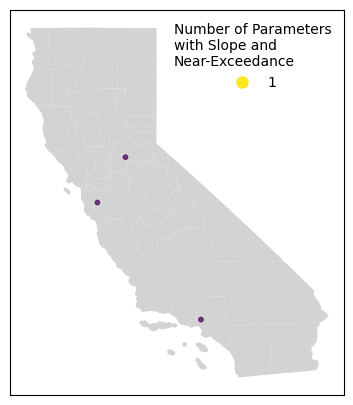

In [43]:
plot_facilities_map(num_parameters_per_facility, 'Number of Parameters\nwith Slope and\nNear-Exceedance', 3)

In [51]:
# make a df with NPDES_CODE and the number of parameters with slope and near exceedance
df = pd.DataFrame(list(num_parameters_per_facility.items()), columns=['NPDES_CODE', 'num_parameters'])
df = df.merge(pd.DataFrame({'NPDES_CODE': data_dict[current_year]['EXTERNAL_PERMIT_NMBR'].unique()}), on='NPDES_CODE', how='right') # add 0 for other facilities
df['num_parameters'] = df['num_parameters'].fillna(0)

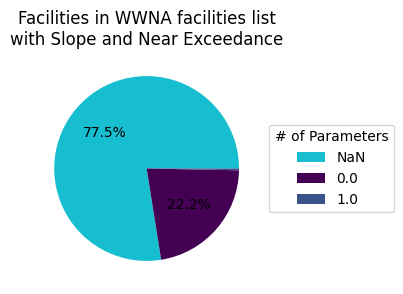

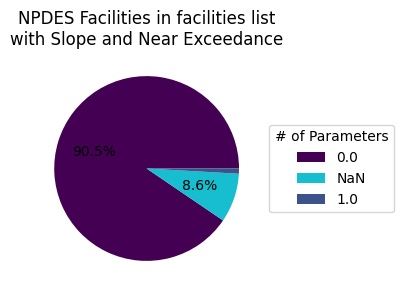

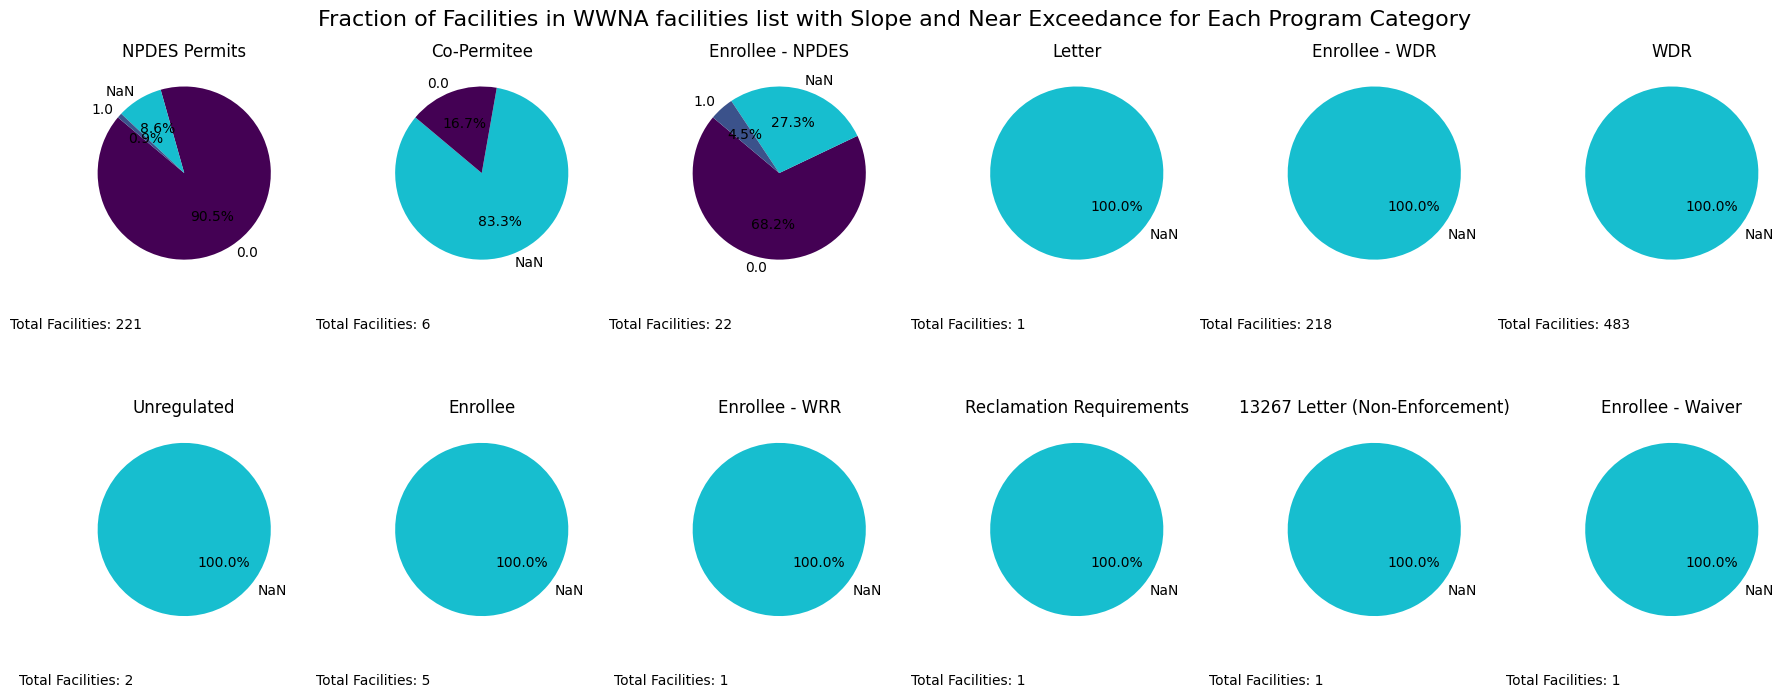

In [52]:
# import ciwqs_facilities and merge df into ciwqs_facilities based on NPDES_CODE
ciwqs_facilities = pd.read_csv('data/facilities_list/NPDES+WDR Facilities List_20240906.csv')
ciwqs_facilities = ciwqs_facilities.merge(df, left_on='NPDES # CA#', right_on='NPDES_CODE', how='left')
ciwqs_facilities.to_csv('processed_data/step3/facilities_with_near_exceedance.csv', index=False)

def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct > 1 else ''

# Predefine color map
color_map = {
    'NaN': '#F0F0F0',  # Light gray for NaN
    None: '#F0F0F0',   # Light gray for None
    np.nan: '#F0F0F0', # Light gray for numpy NaN
    pd.NA: '#F0F0F0',  # Light gray for pandas NA
    np.float64(np.nan): '#F0F0F0', # Light gray for numpy NaN
    '': '#F0F0F0',     # Light gray for empty string
    0: '#440154', # Dark purple for zero
    1: '#3b528b', # Deep blue
    2: '#21908c', # Teal
    3: '#5dc963', # Light green
    4: '#9fda3a', # Lime green
    5: '#d9ef36', # Yellow-green
    6: '#fde725'  # Bright yellow
}

plt.figure(figsize=(3, 3))
value_counts = ciwqs_facilities['num_parameters'].value_counts(dropna=False)
colors = [color_map.get(x, '#17becf') for x in value_counts.index]  # Default color if not in map
wedges, texts, autotexts = plt.pie(value_counts.values, autopct=autopct_format, colors=colors)
plt.legend(wedges, [str(x) if pd.notna(x) else 'NaN' for x in value_counts.index], 
           title="# of Parameters", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Facilities in WWNA facilities list\nwith Slope and Near Exceedance')
plt.show()

plt.figure(figsize=(3, 3))
category_facilities = ciwqs_facilities[ciwqs_facilities['REG MEASURE TYPE'] == 'NPDES Permits']
value_counts = category_facilities['num_parameters'].value_counts(dropna=False)
colors = [color_map.get(x, '#17becf') for x in value_counts.index]  # Default color if not in map
wedges, texts, autotexts = plt.pie(value_counts.values, autopct=autopct_format, colors=colors)
plt.legend(wedges, [str(x) if pd.notna(x) else 'NaN' for x in value_counts.index], 
           title="# of Parameters", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('NPDES Facilities in facilities list\nwith Slope and Near Exceedance')
plt.show()

# Get unique program categories
program_categories = ciwqs_facilities[ciwqs_facilities['REG MEASURE TYPE'].notna()]['REG MEASURE TYPE'].unique()
n_cols = (len(program_categories) + 1) // 2
fig, axs = plt.subplots(2, n_cols, figsize=(3*n_cols, 7), squeeze=False)
fig.suptitle('Fraction of Facilities in WWNA facilities list with Slope and Near Exceedance for Each Program Category', fontsize=16)
axs_flat = axs.flatten()
for idx, program_category in enumerate(program_categories):
    category_facilities = ciwqs_facilities[ciwqs_facilities['REG MEASURE TYPE'] == program_category]
    value_counts = category_facilities['num_parameters'].value_counts(dropna=False)
    colors = [color_map.get(x, '#17becf') for x in value_counts.index]  # Default color if not in map
    axs_flat[idx].pie(value_counts.values, labels=[str(x) if pd.notna(x) else 'NaN' for x in value_counts.index], 
                      autopct='%1.1f%%', startangle=140, colors=colors)
    axs_flat[idx].set_title(f'{program_category}')
    axs_flat[idx].text(0, -0.2, f'Total Facilities: {len(category_facilities)}', ha='center', va='center', transform=axs_flat[idx].transAxes)
for idx in range(len(program_categories), len(axs_flat)):
    fig.delaxes(axs_flat[idx])
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Increase vertical space between subplots
plt.show()


### Print the facilities that do not show up with any parameters having slope and near exceedance

In [47]:
unique_facilities = ciwqs_facilities[~ciwqs_facilities['NPDES # CA#'].isin(df['NPDES_CODE'])][['FACILITY ID', 'FACILITY NAME', 'WDID', 'NPDES # CA#']].drop_duplicates()
print(f'{len(unique_facilities)} facilities in CIWQS facilities list do not have a match in data_dict')
# print(unique_facilities.to_string(index=False)) # uncomment to print the facilities

755 facilities in CIWQS facilities list do not have a match in data_dict


In [48]:
## Print the most frequent parameter codes and their corresponding descriptions with value counts
dmr_esmr_ir_mapping = pd.read_csv('processed_data/step1/dmr_esmr_mapping.csv')
most_frequent_parameter_codes = facilities_with_slope_and_near_exceedance_df['PARAMETER_CODE'].value_counts()

for code, value_count in most_frequent_parameter_codes.items():
    desc = dmr_esmr_ir_mapping.loc[dmr_esmr_ir_mapping['PARAMETER_CODE'] == code, 'ESMR_PARAMETER_DESC'].values
    if len(desc) > 0:
        if desc[0] == 'No Match (confirmed)':
            parameter_desc = dmr_esmr_ir_mapping.loc[dmr_esmr_ir_mapping['PARAMETER_CODE'] == code, 'DMR_PARAMETER_DESC'].values[0]
            print(f'No Match: {value_count}')
            print(f'    DMR: {parameter_desc}')
        else:
            print(f'{desc[0]}: {value_count}')
    else:
        print(f'Unknown parameter (code {code}): {value_count}')


Turbidity: 10
Flow: 1


### Check sensitivity to threshold

In [49]:
# slope_threshold_ranges = [0.02, 0.04, 0.06, 0.08, 0.1]
# limit_threshold_ranges = [0.1, 0.2, 0.3, 0.4, 0.5]
slope_threshold_ranges = [0.01, 0.02]
limit_threshold_ranges = [0.1, 0.2]

number_of_facilities_with_slope_and_near_exceedance = []
for slope_threshold in slope_threshold_ranges:
    for limit_threshold in limit_threshold_ranges:
        facilities_with_slope_and_near_exceedance = get_facilities_with_slope_and_near_exceedance(facility_param_dict, 
                                                                                          slope_threshold, 
                                                                                          limit_threshold)
        number_of_facilities_with_slope_and_near_exceedance.append({
            'count': len(set(facility[0] for facility in facilities_with_slope_and_near_exceedance)),
            'slope_threshold': slope_threshold,
            'limit_threshold': limit_threshold
        })



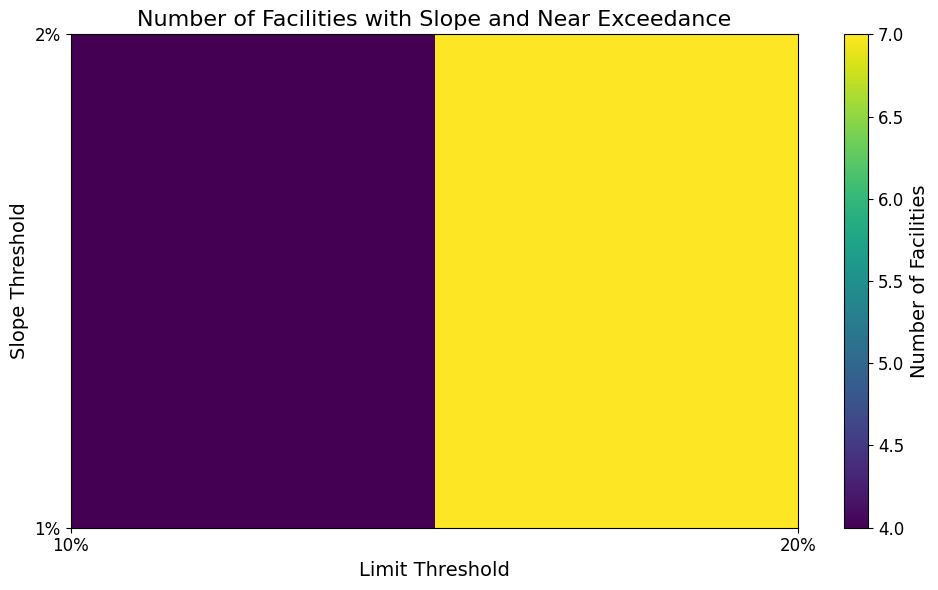

In [50]:
df = pd.DataFrame(number_of_facilities_with_slope_and_near_exceedance)
df_pivot = df.pivot(index='slope_threshold', columns='limit_threshold', values='count')
# Plot as a heatmap with slope_threshold on the y-axis and fraction_threshold on the x-axis
plt.figure(figsize=(10, 6))  # Increased figure size for better visibility
heatmap_data = df_pivot.values
plt.imshow(heatmap_data, aspect='auto', origin='lower', cmap='viridis', extent=[0, len(limit_threshold_ranges)-1, 0, len(slope_threshold_ranges)-1])
cbar = plt.colorbar(label='Number of Facilities')
cbar.ax.set_ylabel('Number of Facilities', fontsize=14)  # Increased font size for colorbar label
cbar.ax.tick_params(labelsize=12)  # Increased font size for colorbar ticks
cbar.ax.tick_params(labelsize=12)  # Increased colorbar tick label size
plt.xticks(range(len(limit_threshold_ranges)), [f'{x*100:.0f}%' for x in limit_threshold_ranges], fontsize=12)
plt.yticks(range(len(slope_threshold_ranges)), [f'{x*100:.0f}%' for x in slope_threshold_ranges], fontsize=12)
plt.xlabel('Limit Threshold', fontsize=14)
plt.ylabel('Slope Threshold', fontsize=14)
plt.title('Number of Facilities with Slope and Near Exceedance', fontsize=16)
plt.tight_layout()
plt.show()